In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import datetime
import logging
import os

import core.config as cconfig
import core.plotting as coplotti
import dataflow.model as dtfmod
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hgit as hgit
import helpers.hparquet as hparque
import helpers.hprint as hprint
import optimizer.forecast_evaluator_with_optimizer as ofevwiop

In [21]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  # Git
  branch_name='CmampTask5066_Create_a_notebook_to_run_backtests_with_the_optimizer'
  hash='9014d7ad7'
  # Last commits:
    * 9014d7ad7 libertasSpZ Delete extra space; add TODO on class cleanup; Checkpoint         (51 minutes ago) Wed Aug 23 18:14:08 2023  (HEAD -> CmampTask5066_Create_a_notebook_to_run_backtests_with_the_optimizer, origin/CmampTask5066_Create_a_notebook_to_run_backtests_with_the_optimizer)
    *   d8d82dd14 libertasSpZ Merge branch 'master' into CmampTask5066_Create_a_notebook_to_run_backtests_with_the_optimizer (57 minutes ago) Wed Aug 23 18:08:16 2023           
    |\  
    | * 4772f7934 Samarth KaPatel CmTask5062_Fix_Stale_Wall_clock_time (#5118)                      (77 minutes ago) Wed Aug 23 17:47:33 2023  (origin/master, origin/HEAD, master)
# Machine info
  system=Linux
  node name=78c41fe47a43
  release=5.15.0-1033-aws
  version=#37~20.04.1-Ubuntu SMP Fri Mar 17 11:39:30 UTC 2023
  machine=x86_64
  processor=x86_64
  cpu count=8
  cpu freq=scpuf

# Build the config

In [22]:
amp_dir = hgit.get_amp_abs_path()
dir_name = os.path.join(
    "/shared_data/model/historical/build_tile_configs.C5b.ccxt_v7_1-all.5T.2019-10-01_2023-07-02.ins.run0/tiled_results",
)
config = {
    "dir_name": dir_name,
    "start_date": datetime.date(2022, 1, 1),
    "end_date": datetime.date(2022, 1, 31),
    "asset_id_col": "asset_id",
    "pnl_resampling_frequency": "15T",
    "annotate_forecasts_kwargs": {
        "style": "longitudinal",
        "quantization": 30,
        "liquidate_at_end_of_day": False,
        "initialize_beginning_of_day_trades_to_zero": False,
        "burn_in_bars": 3,
        "compute_extended_stats": True,
        "target_dollar_risk_per_name": 1e2,
        "modulate_using_prediction_magnitude": True,
    },
    "column_names": {
        "price_col": "vwap",
        "volatility_col": "garman_klass_vol",
        "prediction_col": "feature",
    },
    "bin_annotated_portfolio_df_kwargs": {
        "proportion_of_data_per_bin": 0.2,
        "output_col": "pnl_in_bps",
        "normalize_prediction_col_values": False,
    },
}
config = cconfig.Config().from_dict(config)
print(config)

dir_name: /shared_data/model/historical/build_tile_configs.C5b.ccxt_v7_1-all.5T.2019-10-01_2023-07-02.ins.run0/tiled_results
start_date: 2022-01-01
end_date: 2022-01-31
asset_id_col: asset_id
pnl_resampling_frequency: 15T
annotate_forecasts_kwargs: 
  style: longitudinal
  quantization: 30
  liquidate_at_end_of_day: False
  initialize_beginning_of_day_trades_to_zero: False
  burn_in_bars: 3
  compute_extended_stats: True
  target_dollar_risk_per_name: 100.0
  modulate_using_prediction_magnitude: True
column_names: 
  price_col: vwap
  volatility_col: garman_klass_vol
  prediction_col: feature
bin_annotated_portfolio_df_kwargs: 
  proportion_of_data_per_bin: 0.2
  output_col: pnl_in_bps
  normalize_prediction_col_values: False


# Load tiled results

## Report tile stats

In [23]:
parquet_tile_analyzer = dtfmod.ParquetTileAnalyzer()
parquet_tile_metadata = parquet_tile_analyzer.collate_parquet_tile_metadata(
    config["dir_name"]
)

In [24]:
parquet_tile_analyzer.compute_metadata_stats_by_asset_id(parquet_tile_metadata)

,n_years,n_unique_months,n_files,size
asset_id,,,,
1030828978,2,12,17,19.4 MB
1464553467,5,12,45,57.4 MB
1467591036,5,12,46,61.2 MB
1528092593,3,12,27,30.7 MB
1776791608,3,12,30,35.3 MB
1891737434,4,12,36,43.2 MB
1966583502,4,12,35,44.0 MB
2099673105,4,12,35,40.6 MB
2237530510,4,12,35,43.6 MB


In [25]:
parquet_tile_analyzer.compute_universe_size_by_time(parquet_tile_metadata)

n_asset_ids     size
year month                      
2019 10               1   1.2 MB
     11               2   1.3 MB
     12               2   2.6 MB
2020 1                4   4.1 MB
     2                5   5.7 MB
     3                5   6.4 MB
     4                5   6.1 MB
     5                5   6.1 MB
     6                5   5.9 MB
     7                6   7.2 MB
     8                8   8.9 MB
     9               14  14.2 MB
     10              16  18.8 MB
     11              18  21.2 MB
     12              18  23.6 MB
2021 1               19  25.0 MB
     2               20  24.6 MB
     3               20  28.2 MB
     4               21  28.9 MB
     5               22  30.0 MB
     6               22  28.8 MB
     7               22  29.1 MB
     8               22  29.7 MB
     9               23  29.8 MB
     10              23  30.9 MB
     11              23  30.1 MB
     12              23  30.8 MB
2022 1               23  30.6 MB
     2               23  26.8 MB
     3               25  31.1 MB
     4               25  31.5 MB
     5               25  32.3 MB
     6               25  30.6 MB
     7               25  30.9 MB
     8               25  30.8 MB
     9               25  28.8 MB
     10              25  28.9 MB
     11              25  29.7 MB
     12              25  29.0 MB
2023 1               25  30.9 MB
     2               25  27.6 MB
     3               25  30.5 MB
     4               25  28.9 MB
     5               25  28.7 MB
     6               25  28.6 MB
     7               25   2.2 MB

In [26]:
asset_ids = parquet_tile_metadata.index.levels[0].to_list()
display(asset_ids)

[1030828978,
 1464553467,
 1467591036,
 1528092593,
 1776791608,
 1891737434,
 1966583502,
 2099673105,
 2237530510,
 2384892553,
 2425308589,
 2476706208,
 2484635488,
 2540896331,
 2601760471,
 2683705052,
 3065029174,
 3401245610,
 4516629366,
 5115052901,
 5118394986,
 6051632686,
 8717633868,
 8968126878,
 9872743573]

## Load a single-asset tile

In [27]:
asset_batch_size = 1
cols = None
single_asset_tile = next(
    hparque.yield_parquet_tiles_by_assets(
        config["dir_name"],
        asset_ids[0:1],
        config["asset_id_col"],
        asset_batch_size,
        cols,
    )
)

  0%|          | 0/1 [00:00<?, ?it/s]

In [28]:
single_tile_df = dtfmod.process_parquet_read_df(
    single_asset_tile, config["asset_id_col"]
)

In [29]:
single_tile_df.columns.levels[0].to_list()

['close',
 'close.ret_0',
 'close_vol',
 'feature',
 'feature_raw',
 'feature_raw.c',
 'garman_klass_vol',
 'high',
 'low',
 'month',
 'open',
 'parkinson_vol',
 'twap',
 'twap.ret_0',
 'volume',
 'vwap',
 'vwap.ret_0',
 'vwap.ret_0.vol_adj',
 'vwap.ret_0.vol_adj.c',
 'year']

In [30]:
single_tile_df.head(3)

,close,close.ret_0,close_vol,feature,feature_raw,feature_raw.c,garman_klass_vol,high,low,month,open,parkinson_vol,twap,twap.ret_0,volume,vwap,vwap.ret_0,vwap.ret_0.vol_adj,vwap.ret_0.vol_adj.c,year
asset_id,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978,1030828978
end_ts,,,,,,,,,,,,,,,,,,,,
2022-03-15 04:05:00+00:00,0.32974,NaN,NaN,NaN,NaN,NaN,0.051465,0.33431,0.31000,3,0.32230,0.045340,0.323994,NaN,1710307.0,0.326079,NaN,NaN,NaN,2022
2022-03-15 04:10:00+00:00,0.32690,-0.008650,0.008650,NaN,NaN,NaN,0.013215,0.33072,0.32432,3,0.32903,0.011736,0.327388,0.010421,1344264.0,0.327638,0.004770,NaN,NaN,2022
2022-03-15 04:15:00+00:00,0.32569,-0.003708,0.003708,NaN,NaN,NaN,0.005931,0.32724,0.32440,3,0.32657,0.005235,0.325566,-0.005581,505779.0,0.325527,-0.006463,NaN,NaN,2022


# Compute portfolio bar metrics when forecasting from price without optimizer.

In [31]:
forecast_evaluator = dtfmod.ForecastEvaluatorFromPrices
portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    config["column_names"]["price_col"],
    config["column_names"]["volatility_col"],
    config["column_names"]["prediction_col"],
    asset_ids=None,
    annotate_forecasts_kwargs=config["annotate_forecasts_kwargs"].to_dict(),
    return_portfolio_df=True,
    forecast_evaluator=forecast_evaluator,
    optimizer_config_dict=None,
)

  0%|          | 0/1 [00:00<?, ?it/s]

INFO  spread is `None`; imputing spread_lower_bound=0.000100


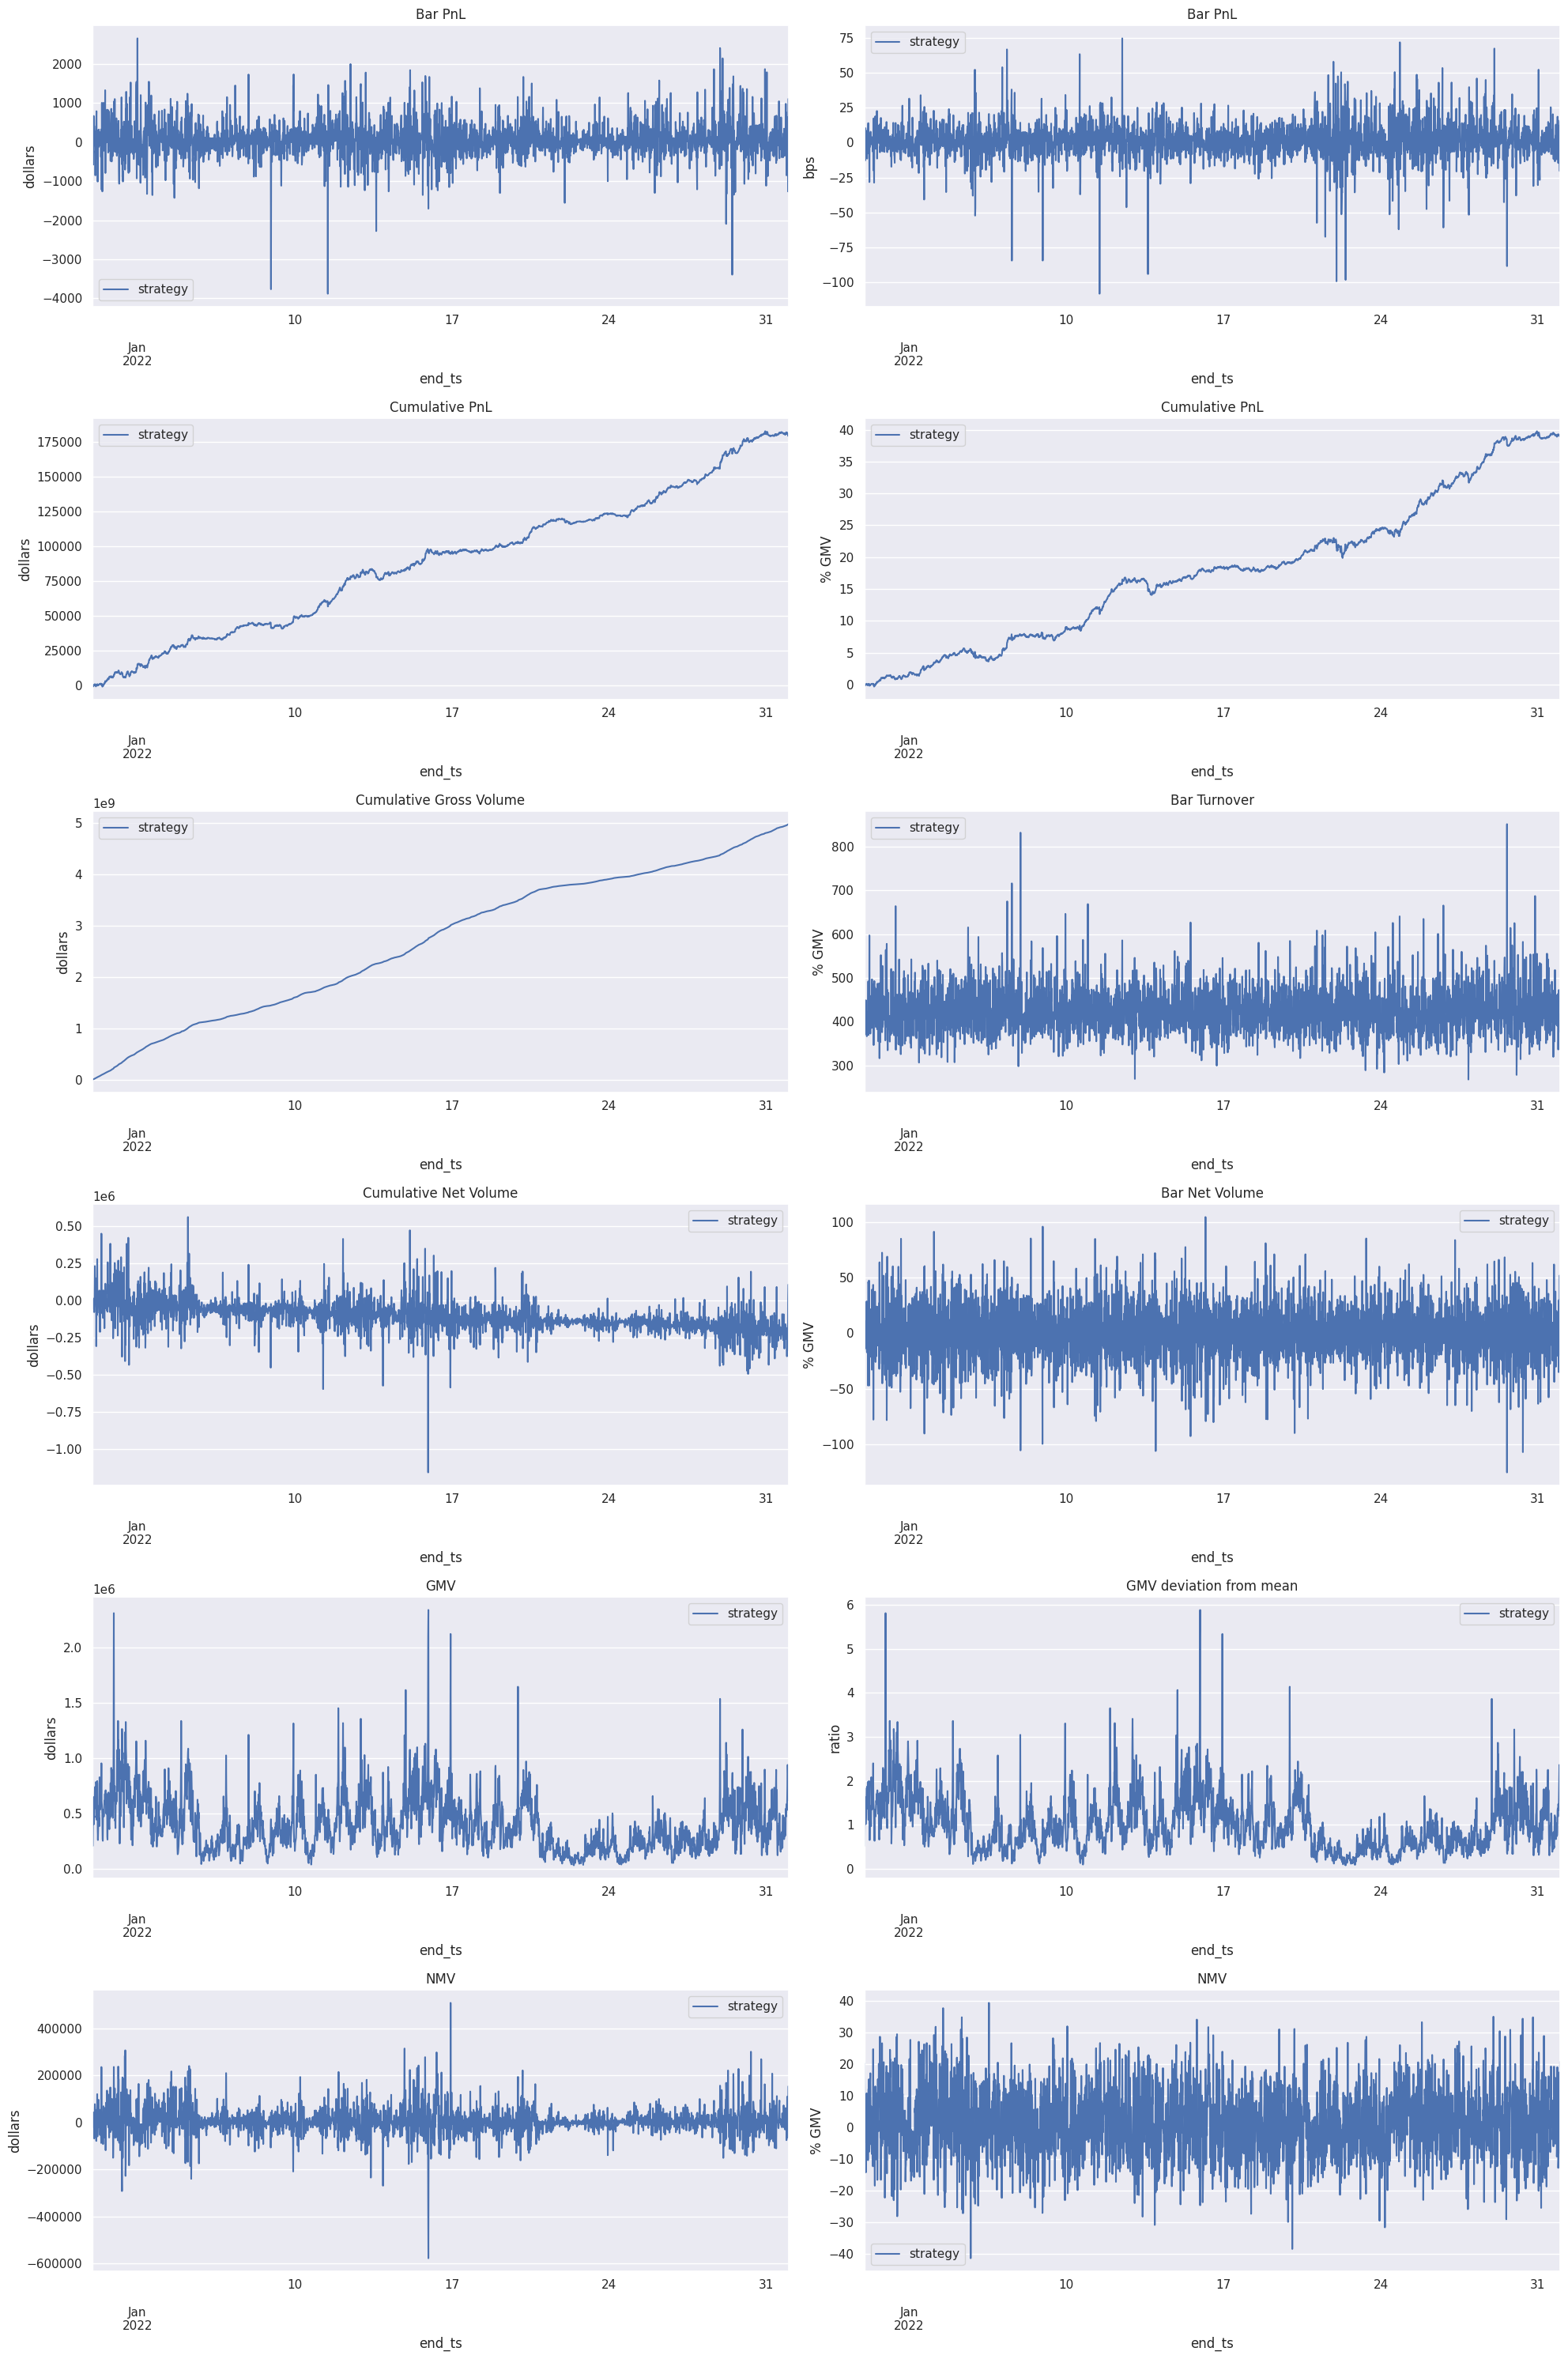

In [32]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

# Compute portfolio bar metrics when forecasting, with optimizer.

In [35]:
forecast_evaluator = ofevwiop.ForecastEvaluatorWithOptimizer
optimizer_config_dict = {
    "dollar_neutrality_penalty": 0.9,
    "volatility_penalty": 1.0,
    "relative_holding_penalty": 3.0,
    "relative_holding_max_frac_of_gmv": 0.6,
    "target_gmv": 1e4,
    "target_gmv_upper_bound_penalty": 0.95,
    "target_gmv_hard_upper_bound_multiple": 1.00,
    "turnover_penalty": 0.09,
    "solver": "ECOS",
}
portfolio_df, bar_metrics = dtfmod.annotate_forecasts_by_tile(
    config["dir_name"],
    config["start_date"],
    config["end_date"],
    config["asset_id_col"],
    config["column_names"]["price_col"],
    config["column_names"]["volatility_col"],
    config["column_names"]["prediction_col"],
    asset_ids=None,
    annotate_forecasts_kwargs=config["annotate_forecasts_kwargs"].to_dict(),
    return_portfolio_df=True,
    forecast_evaluator=forecast_evaluator,
    optimizer_config_dict=optimizer_config_dict,
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8928 [00:00<?, ?it/s]

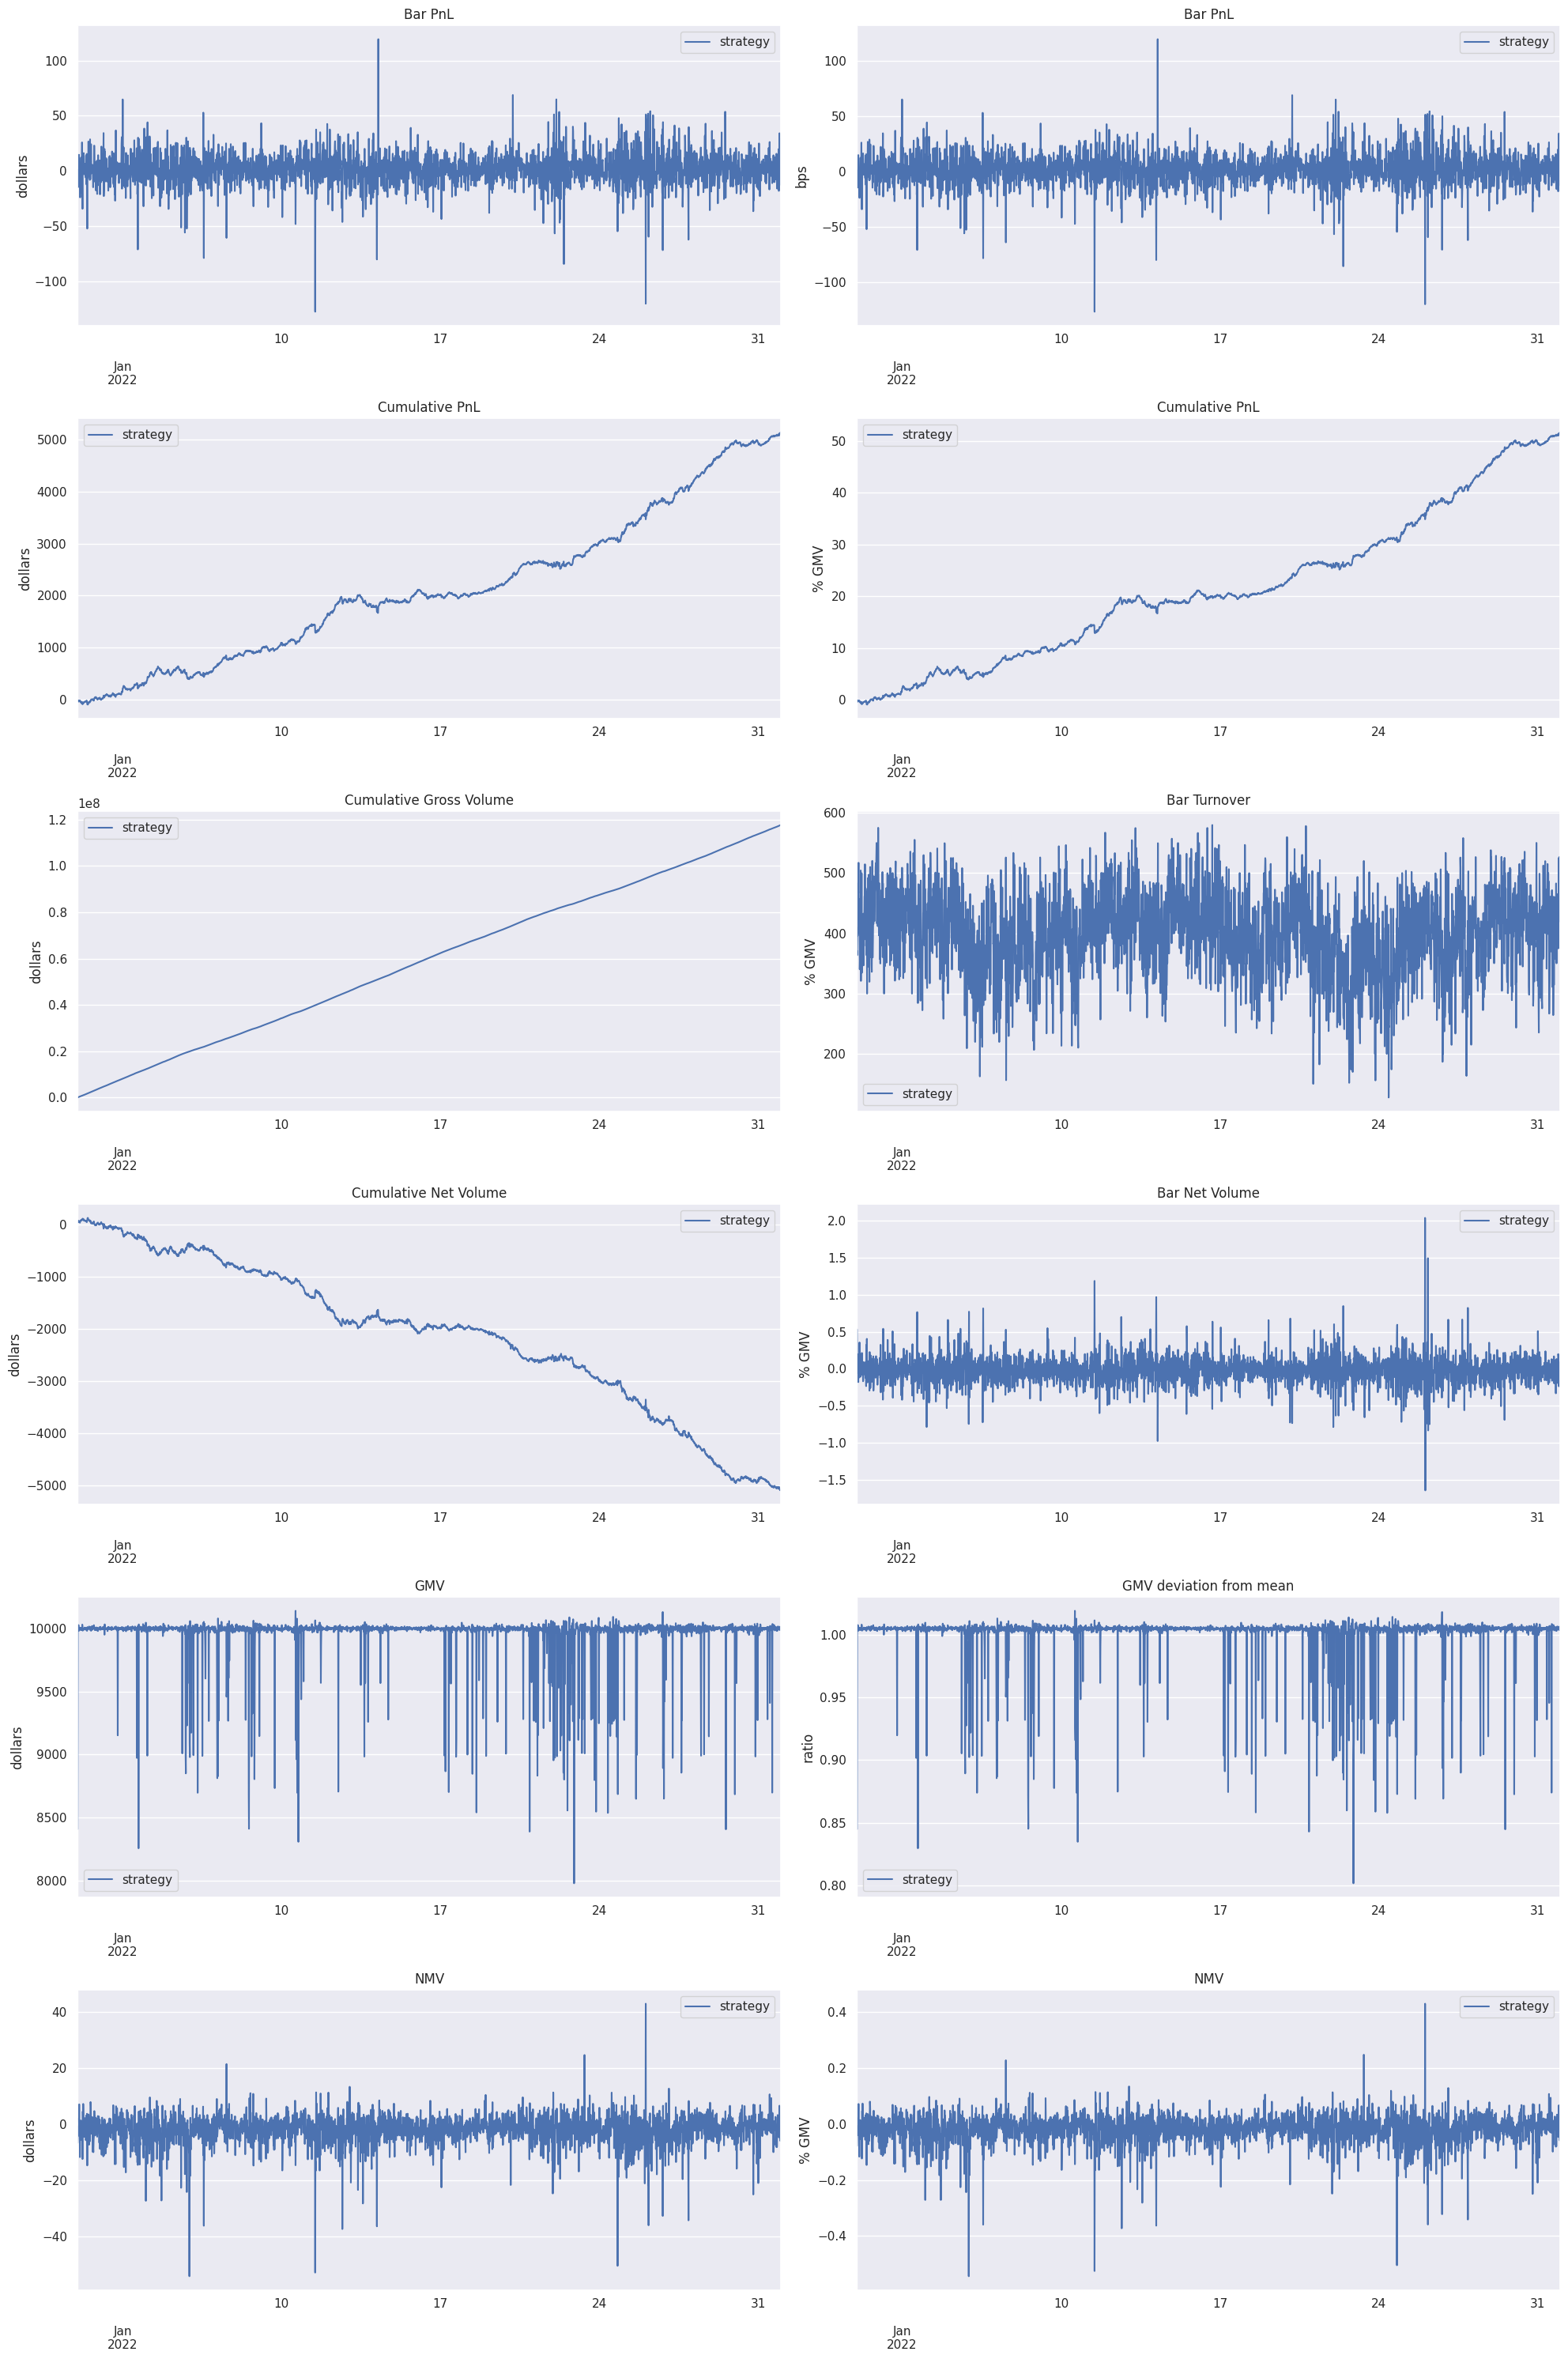

In [36]:
coplotti.plot_portfolio_stats(
    bar_metrics, freq=config["pnl_resampling_frequency"]
)

# Compute aggregate portfolio stats

In [37]:
stats_computer = dtfmod.StatsComputer()

In [38]:
portfolio_stats, daily_metrics = stats_computer.compute_portfolio_stats(
    bar_metrics,
    config["pnl_resampling_frequency"],
)
display(portfolio_stats)

ratios      sharpe_ratio                      22.68
            sharpe_ratio_standard_error        3.45
            sr.tval                            6.61
            sr.pval                            0.00
            kratio                            16.75
dollar      gmv_mean                        9952.07
            gmv_stdev                        209.26
            annualized_mean_return         60574.36
            annualized_volatility           2671.13
            max_drawdown                     344.95
            pnl_mean                           1.73
            pnl_std                           14.27
            turnover_mean                  39572.28
            turnover_stdev                  7031.16
            market_bias_mean                  -2.00
            market_bias_stdev                  5.26
percentage  annualized_mean_return           608.66
            annualized_volatility             26.84
            max_drawdown                       3.47
            